In [92]:
from pathlib import Path
import matplotlib.pyplot as plt
import pyvista as pv
import numpy as np
import os
from typing import Tuple
import pandas as pd

# Loading Petrel surfaces into Python

Our example dataset are some faults and horizons exported from Petrel as Earth Vision grids, because why not.

In [93]:
folder = Path("./data/surfaces/")

So let's first write a script to load these obscure Earth Vision grid files. The files have the following structure:

    # Type: scattered data
    # Version: 6
    # Description: No description
    # Format: free
    # Field: 1 x
    # Field: 2 y
    # Field: 3 z milliseconds
    # Field: 4 column
    # Field: 5 row
    # Projection: Local Rectangular
    # Units: meters
    # End:
    # Information from grid:
    # Grid_size: 144 x 131
    # Grid_space: 1.355556, 2.355556,6780279.1,2.716996
    # Scattered data: Not_available
    # Z_field: z
    # Vertical_faults: Not_available
    # History: No history
    # Z_units: milliseconds
    1.355556 4.716996 -1117.917114 79 2
    2.355556 5.716996 -1218.035156 80 2
    3.355556 6.716996 -1118.361938 81 2
    ...

In [115]:
def read_earth_vision_grid(
    fp: Path, 
    return_header: bool = False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Read Earth Vision grid file into useful numpy ndarrays.
    
    Args:
        fp (Path): Filepath of the Earth Vision grid file.
        return_header (bool): Returns the heder data as a dictionary.
            Defaults to False.
    Returns:
        (tuple) of X, Y, Z ndarrays than can be directly turned
            into a pyvista.StructuralGrid.
    """
    n_header = 19  # number of header lines in the file format
    header = {}
    
    with open(fp) as f:
        lines = f.readlines()
        
    for i, line in enumerate(lines):
        line = line.rstrip("\n")
        # wrangle in header data
        if i <= n_header:
            key, value = line.split(":")
            key = key.lstrip("# ")

            # handle special cases of interest
            if key == "Grid_space":  # this is the bounding box of the grid
                value = [float(v) for v in value.split(",")]
            elif key == "Grid_size":  # this is the number of grid cells per axis
                value = [int(v) for v in value.split("x")]
                Z = np.empty(value[::-1])
                Z[:] = np.nan
                
            header[key] = value
        # wrangle the grid data
        else:
            x, y, z, gx, gy = (float(l) for l in line.split(" "))
            Z[int(gy) -1, int(gx) -1] = z  # -1 because 0 indexing in python

    xcoord = np.linspace(*header["Grid_space"][:2], header["Grid_size"][0])
    ycoord = np.linspace(*header["Grid_space"][2:], header["Grid_size"][1])
    X, Y = np.meshgrid(xcoord, ycoord)
    
    if return_header:
        return X, Y, Z, header
    else:
        return X, Y, Z

Now let's try this on a fault surface:

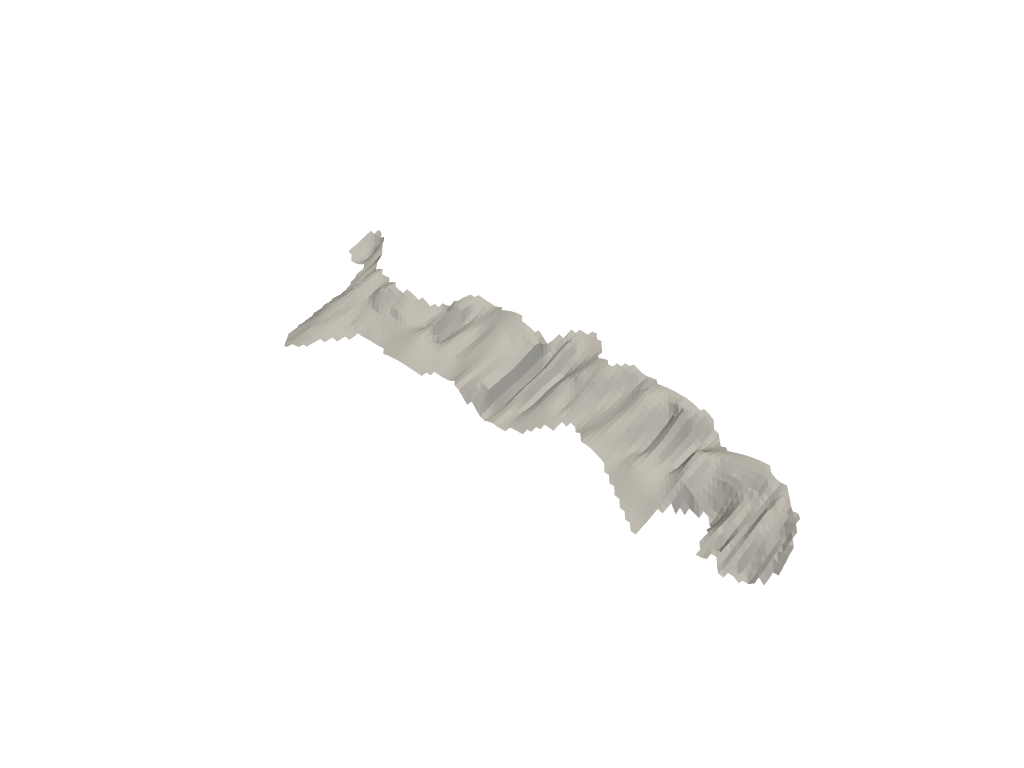

In [124]:
x, y, z = read_earth_vision_grid(folder / "fault3")
grid = pv.StructuredGrid(x, y, z)
grid.plot(color="lightgrey")

Now that we've seen that it works, let's load all available surfaces from the data folder:

In [130]:
surface_grids = {}
for surface in os.listdir(folder):
    try:
        x, y, z = read_earth_vision_grid(folder / surface)
    except FileNotFoundError:
        continue
    grid = pv.StructuredGrid(x, y, z)
    # for GemPy, we not only need surface points, but also surface
    # orientations. But we can't simply calculate the surface normals
    # from the StructuredGrid using pyvista - so we convert them to
    # triangulated grids and compute the surface normals there
    ugrid = grid.triangulate()
    trisurf = ugrid.extract_surface().compute_normals()
    surface_grids[surface] = trisurf
    

And plot them using `pyvista`

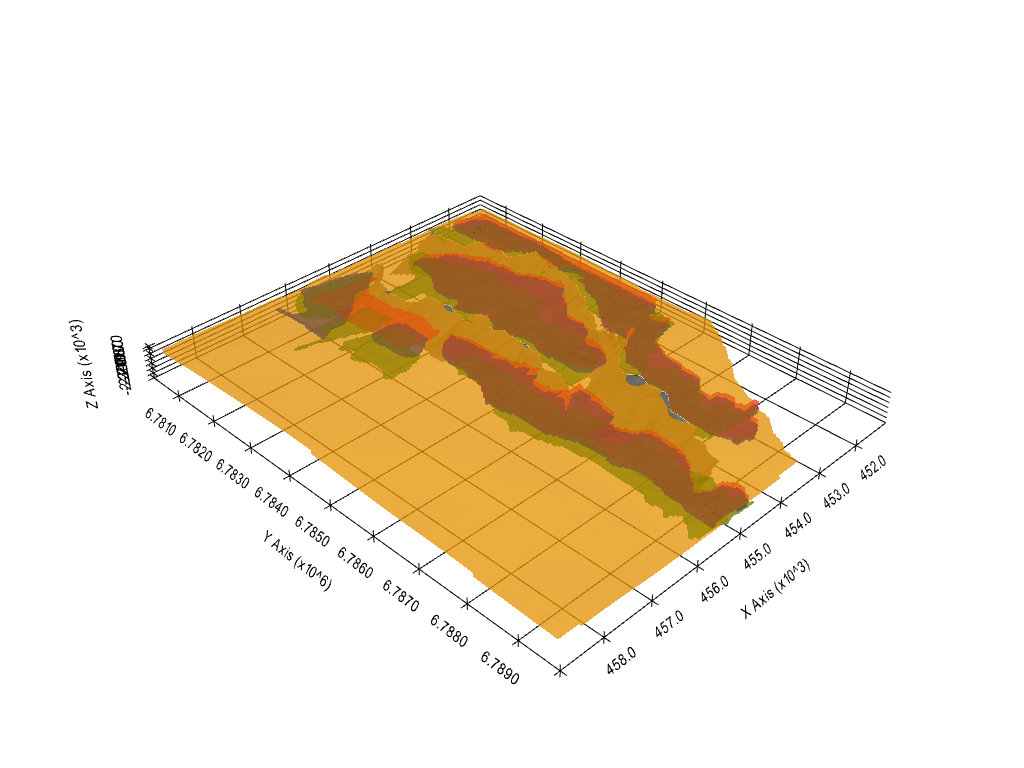

In [128]:
p = pv.Plotter(notebook=True)  # switch this to False for interactive plotting
for name, grid in surface_grids.items():
    opacity = 0.75
    if name == "BCU":
        color="orange"
    elif "fault" in name:
        opacity = 1
        color = "grey"
    elif "tarbert" in name:
        color = "#ff3f20"
    elif "ness" in name:
        color = "#443988"
    elif "etive" in name:
        color = "#728f02"
        
    p.add_mesh(grid, color=color, opacity=opacity)
p.show_grid()
p.show()

## Plotting surface normals used for GemPy orientations

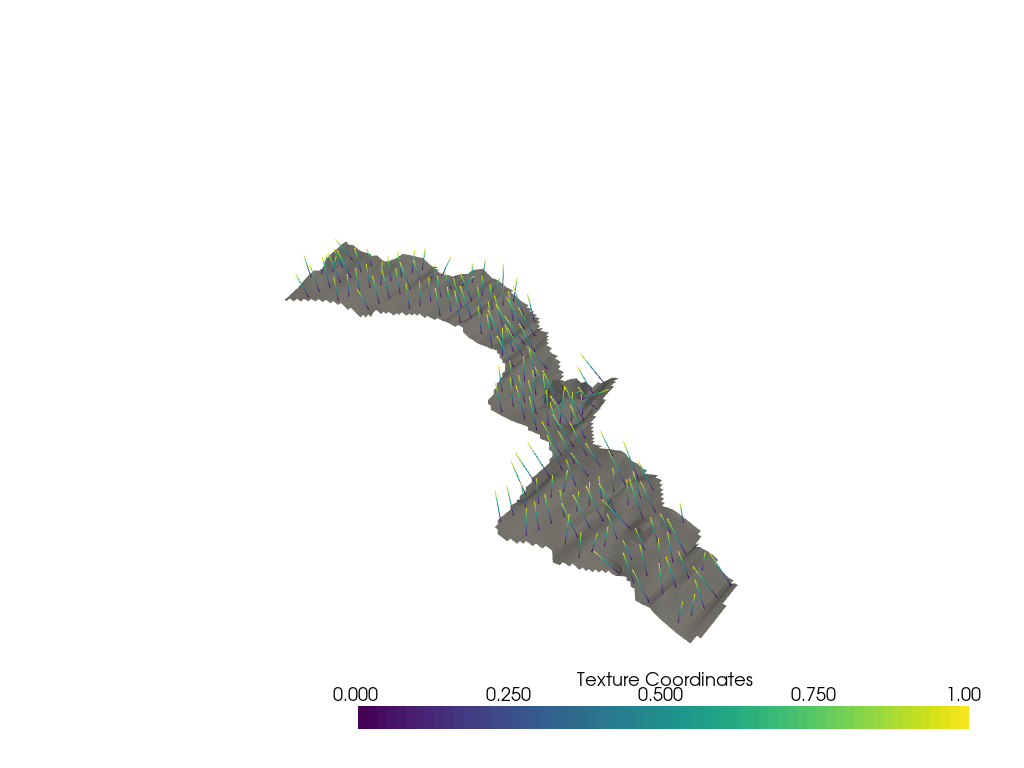

In [131]:
grid = surface_grids["fault4"]
p = pv.Plotter(notebook=True)

for point, normal in zip(grid.points[::20], grid.point_normals[::20]):
    line = pv.Line(
        point, point + normal * -500
    )
    p.add_mesh(line)
    
p.add_mesh(grid, color="grey")
p.show()

## Converting to GemPy input data

In [136]:
surfp_columns = "X Y Z surface".split()
orient_columns = "X Y Z G_x G_y G_z surface".split()

surface_points = pd.DataFrame(columns=surfp_columns)
orientations = pd.DataFrame(columns=orient_columns)


for name, grid in surface_grids.items():
    name = name.split(" ")
    surface = name[0]
    faultblock = name[1] if len(name) > 1 else None
        
    print(f"{surface}: {grid.points.shape[0]} surface points and orientations")
    surface_points = surface_points.append(pd.DataFrame(
        dict(
            X=grid.points[:, 0],
            Y=grid.points[:, 1],
            Z=grid.points[:, 2],
            surface=surface,
            faultblock=faultblock
        )
    ), ignore_index=True)

    orientations = orientations.append(pd.DataFrame(
        dict(
            X=grid.points[:, 0],
            Y=grid.points[:, 1],
            Z=grid.points[:, 2],
            surface=surface,
            faultblock=faultblock,
            G_x=grid.point_normals[:, 0] * -1,
            G_y=grid.point_normals[:, 1] * -1,
            G_z=grid.point_normals[:, 2] * -1,
            polarity=1
        )
    ), ignore_index=True)
    
surface_points = surface_points[pd.notna(surface_points.Z)].reset_index(drop=True)
orientations = orientations[pd.notna(orientations.Z)].reset_index(drop=True)
orientations = orientations[pd.notna(orientations.G_x)].reset_index(drop=True)

BCU: 29414 surface points and orientations
etive: 9499 surface points and orientations
etive: 4944 surface points and orientations
etive: 4130 surface points and orientations
etive: 1035 surface points and orientations
etive: 782 surface points and orientations
etive: 1023 surface points and orientations
fault3: 4838 surface points and orientations
fault4: 12024 surface points and orientations
ness: 9018 surface points and orientations
ness: 4559 surface points and orientations
ness: 4550 surface points and orientations
ness: 1715 surface points and orientations
ness: 480 surface points and orientations
tarbert: 9018 surface points and orientations
tarbert: 4559 surface points and orientations
tarbert: 4224 surface points and orientations
tarbert: 1643 surface points and orientations


<div class="alert alert-warning">
Now we have about 60000 input data points for GemPy - which is just a ridiculous amount to parameterize such simple surfaces. GemPy excells in environments of low data density, making full use of its interpolation function. Thus, to turn this into a GemPy model, we have to decimate the input data.
</div>

In [137]:
surface_points.tail()

,X,Y,Z,surface,faultblock
61064,455846.3125,6782206.5,-1820.584839,tarbert,E
61065,455846.3125,6782256.5,-1815.484009,tarbert,E
61066,455846.3125,6782306.5,-1811.679199,tarbert,E
61067,455846.3125,6782956.5,-1807.024658,tarbert,E
61068,455846.3125,6783006.5,-1812.304932,tarbert,E


In [138]:
orientations.tail()

,X,Y,Z,G_x,G_y,G_z,surface,faultblock,polarity
55741,455796.3125,6782106.5,-1814.896851,0.084554,-0.081781,0.993057,tarbert,E,1.0
55742,455796.3125,6782156.5,-1815.516968,0.033015,0.050892,0.998158,tarbert,E,1.0
55743,455796.3125,6782206.5,-1820.696289,-0.071557,0.089166,0.993443,tarbert,E,1.0
55744,455796.3125,6782256.5,-1827.633301,-0.159186,0.038600,0.986494,tarbert,E,1.0
55745,455796.3125,6782956.5,-1808.008301,-0.150360,0.137975,0.978956,tarbert,E,1.0
